# Realistic Network: Analysis of Leios simulations at tag `leios-2025w11`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Receipt of messages

### Read results

In [2]:
if (file.exists("results/receipts.csv.gz")) {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
} else {
    receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w11xl", collection="receipts")$find(), stringsAsFactors=TRUE)
    fwrite(receipts, "results/receipts.csv")
}
receipts %>% summary

    elapsed         ib-body-avg-size-bytes ib-generation-probability
 Min.   :  0.0000   Min.   : 32768         Min.   : 0.30            
 1st Qu.:  0.3331   1st Qu.: 98304         1st Qu.: 3.00            
 Median :  0.6743   Median : 98304         Median :30.00            
 Mean   :  2.0195   Mean   :118054         Mean   :19.36            
 3rd Qu.:  0.9676   3rd Qu.:163840         3rd Qu.:30.00            
 Max.   :592.0710   Max.   :163840         Max.   :30.00            
                                                                    
            item           kind               label          
              :   735000   EB:   375000   default:156526292  
 120-node-1907:    33000   IB:109171292                      
 420-node-1976:    33000   RB:   735000                      
 60-node-1869 :    30000   VT: 46245000                      
 300-node-1985:    27000                                     
 360-node-1924:    27000                                     
 (Other)      

### Scenarios present in dataset

In [3]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
rust,realistic,default,156526292


### IB rate vs IB size vs stage length

In [4]:
receiptsDefault <-
receipts[
    `label` == "default" & 
    !is.na(`received`) &
    !(`simulator` == "rust" & `kind` == "RB") &
    `sent` <= 540
]

#### Compare the distributions of elapsed times

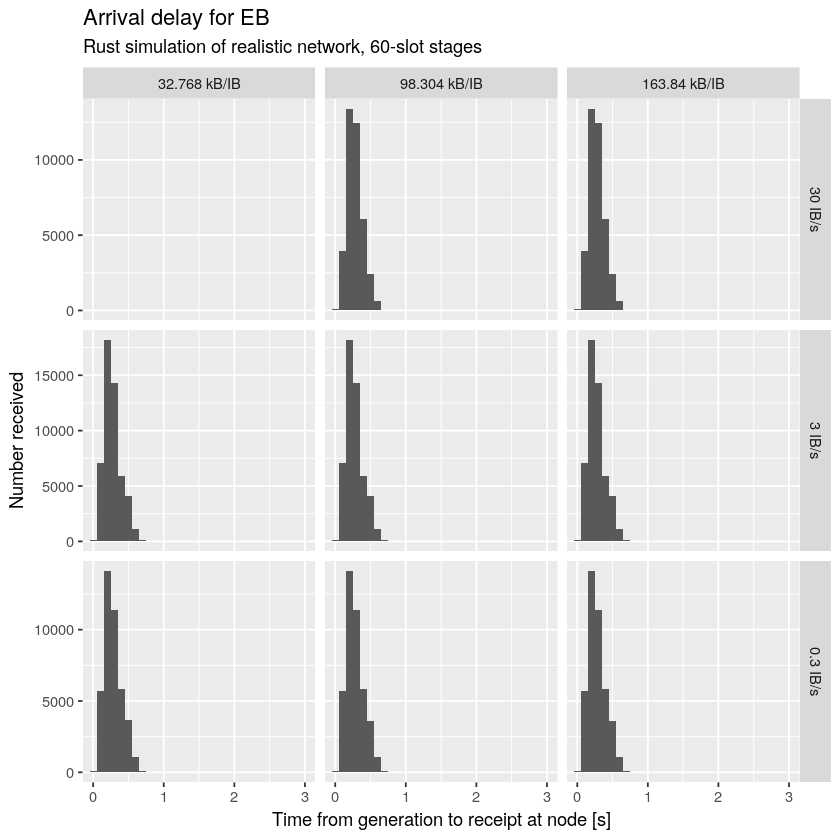

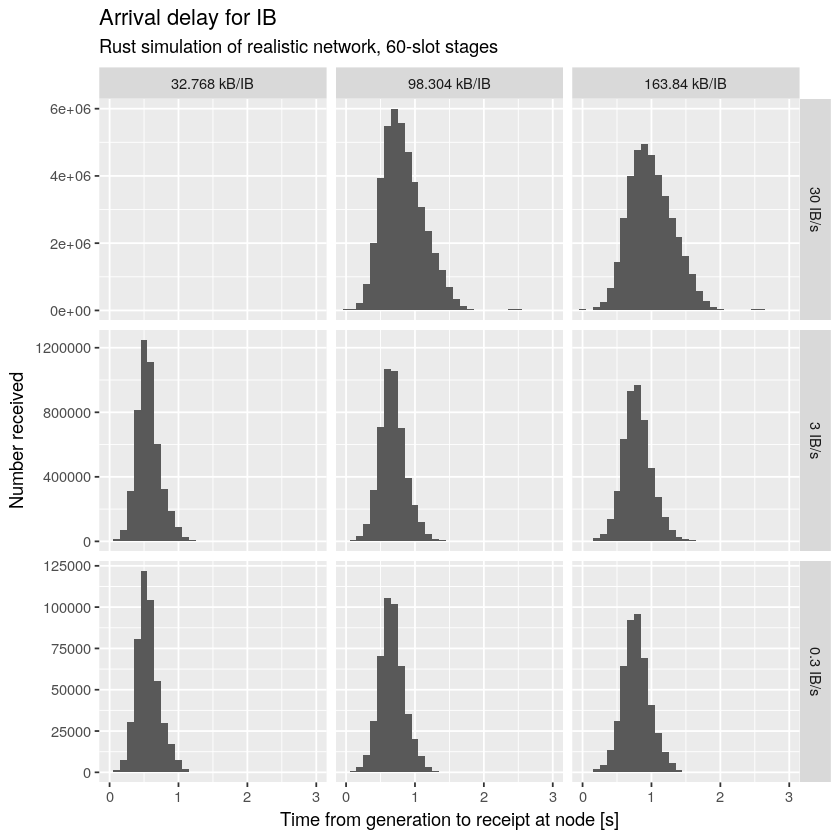

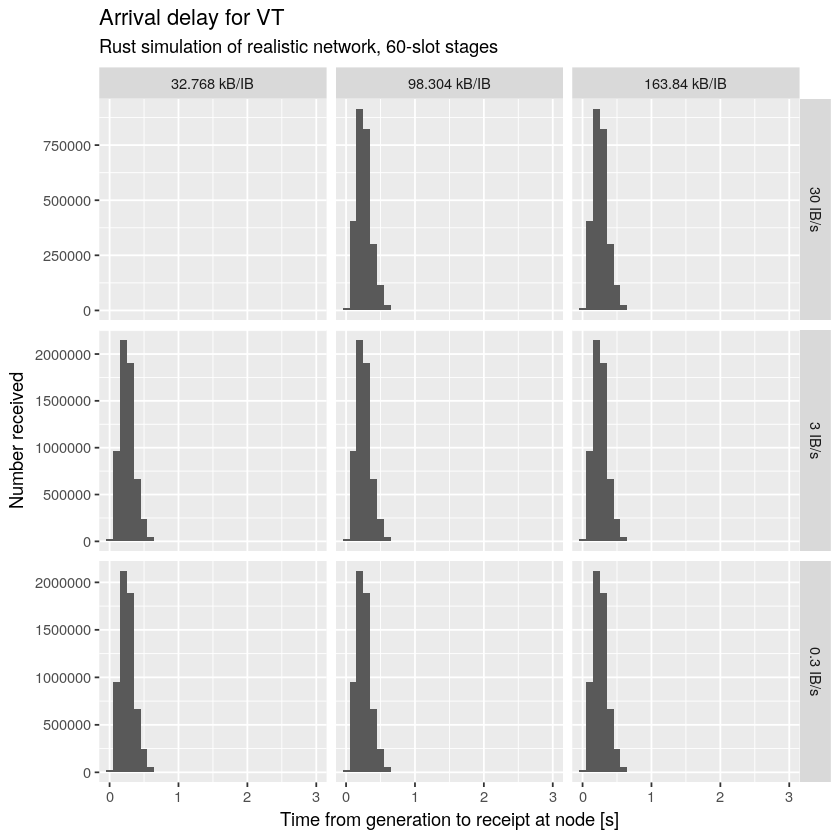

In [6]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in receiptsDefault[,unique(`simulator`)]) {
    g <- ggplot(
        receiptsDefault[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `elapsed`
            )
        ],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("plots/elapsed-", k, "-", s, ".png"), units="in", width=8, height=6, dpi=150)
}
}

### Fraction of items arriving

In [7]:
arrival <- receiptsDefault[,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
]

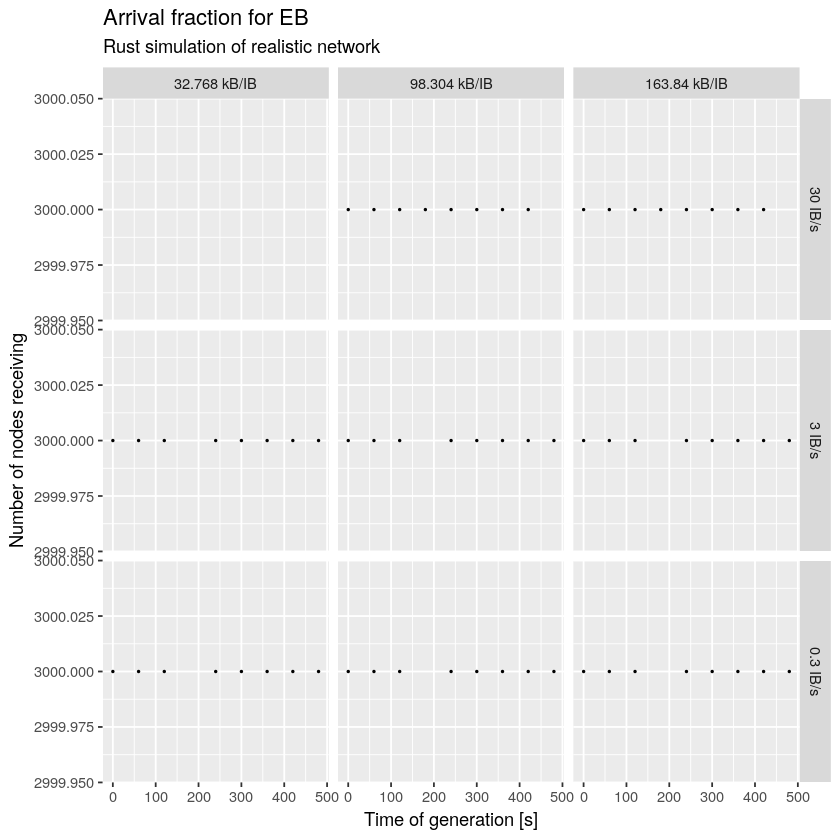

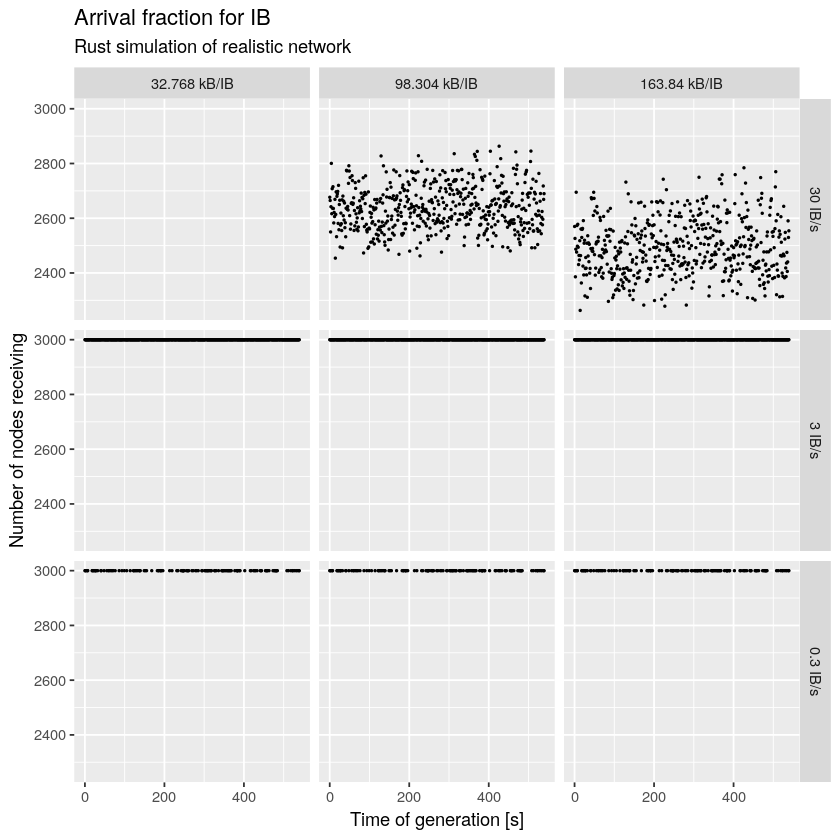

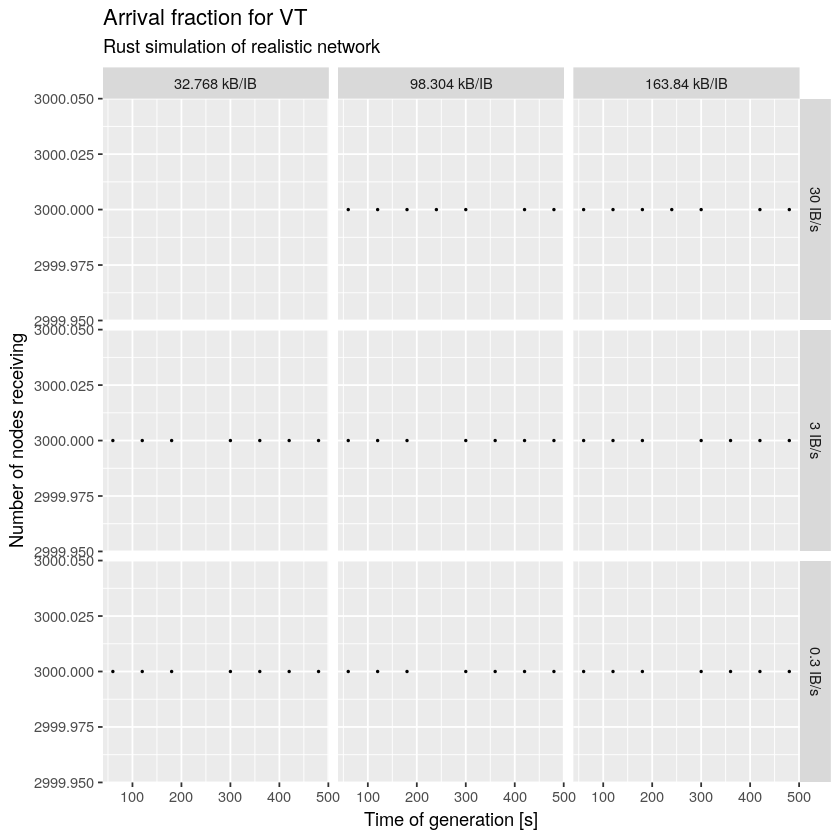

In [8]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in receiptsDefault[,unique(`simulator`)]) {
    g <- ggplot(
        arrival[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.3) +
        facet_grid(`ibRate`  ~ `ibSize`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle=paste(s %>% str_to_title, "simulation of realistic network"))
    print(g)
}
}

## CPU usage

### Read results

In [9]:
if (file.exists("results/cpus.csv.gz")) {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
} else {
    cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w11xl", collection="cpus")$find(), stringsAsFactors=TRUE)
    fwrite(cpus, "results/cpus.csv")
}
cpus %>% summary

    duration        eb-generation-probability ib-body-avg-size-bytes
 Min.   :0.000164   Min.   :1.5               Min.   : 32768        
 1st Qu.:0.135072   1st Qu.:1.5               1st Qu.: 98304        
 Median :0.337680   Median :1.5               Median : 98304        
 Mean   :1.123334   Mean   :1.5               Mean   :109840        
 3rd Qu.:2.306992   3rd Qu.:1.5               3rd Qu.:163840        
 Max.   :6.919744   Max.   :1.5               Max.   :163840        
                                                                    
 ib-generation-probability     label          leios-stage-length-slots
 Min.   : 0.30             default:11161434   Min.   :60              
 1st Qu.: 3.00                                1st Qu.:60              
 Median : 3.00                                Median :60              
 Mean   :12.04                                Mean   :60              
 3rd Qu.:30.00                                3rd Qu.:60              
 Max.   :30.00        

In [10]:
cpusNode <-
cpus[
    `slot` >= 60 & `slot` <= 540,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

### Peak CPU usage

#### Histogram

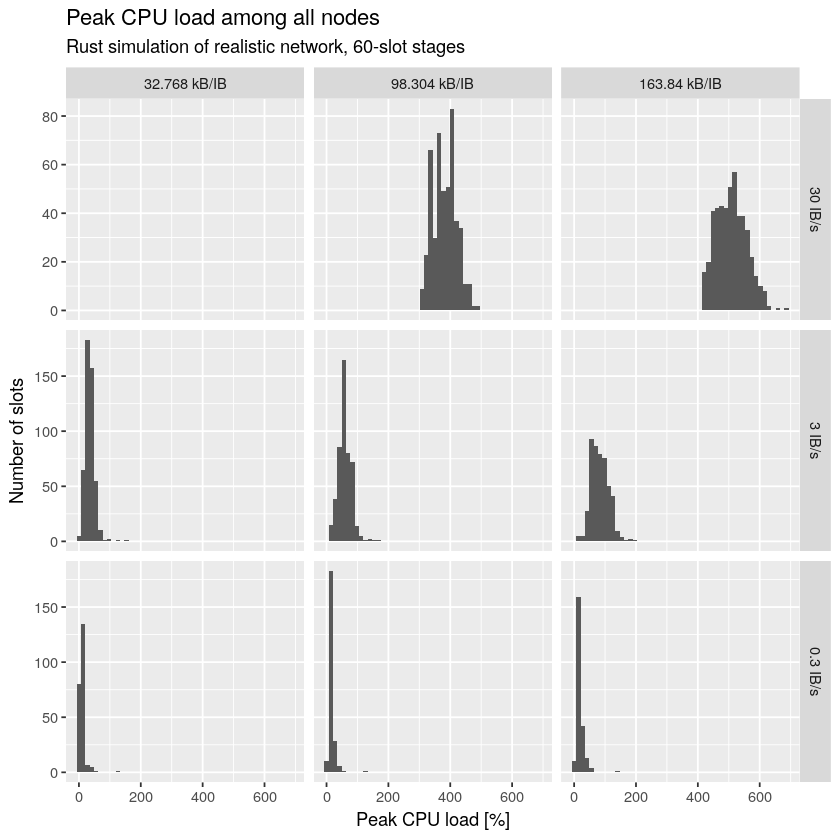

In [11]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(bins=50) +
#   geom_vline(xintercept=100, color="blue") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

#### Time series

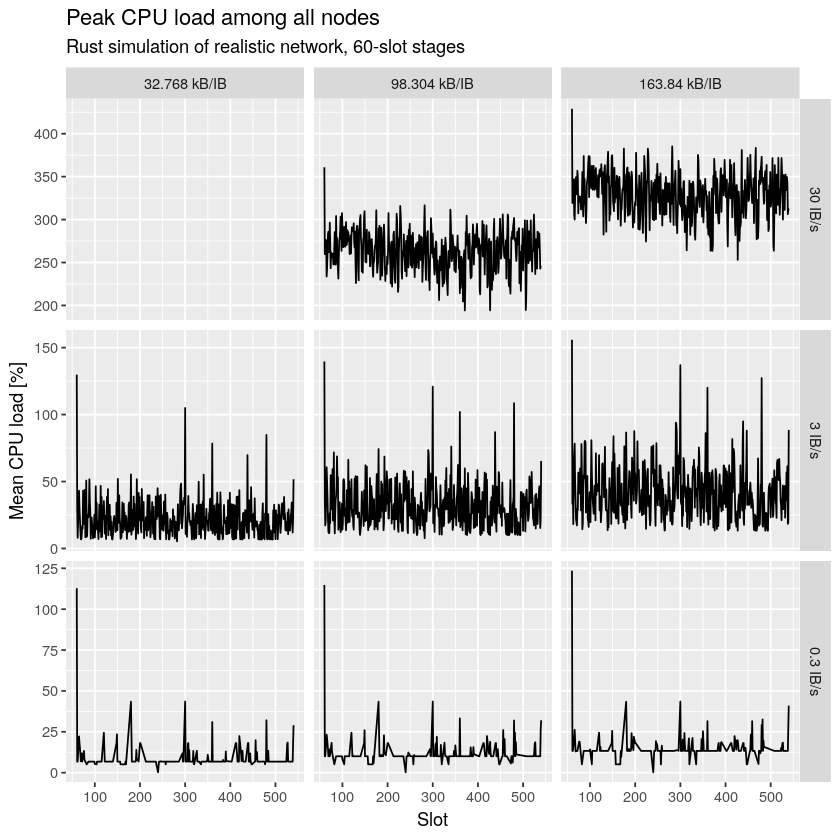

In [12]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

### Mean CPU usage

#### Histogram

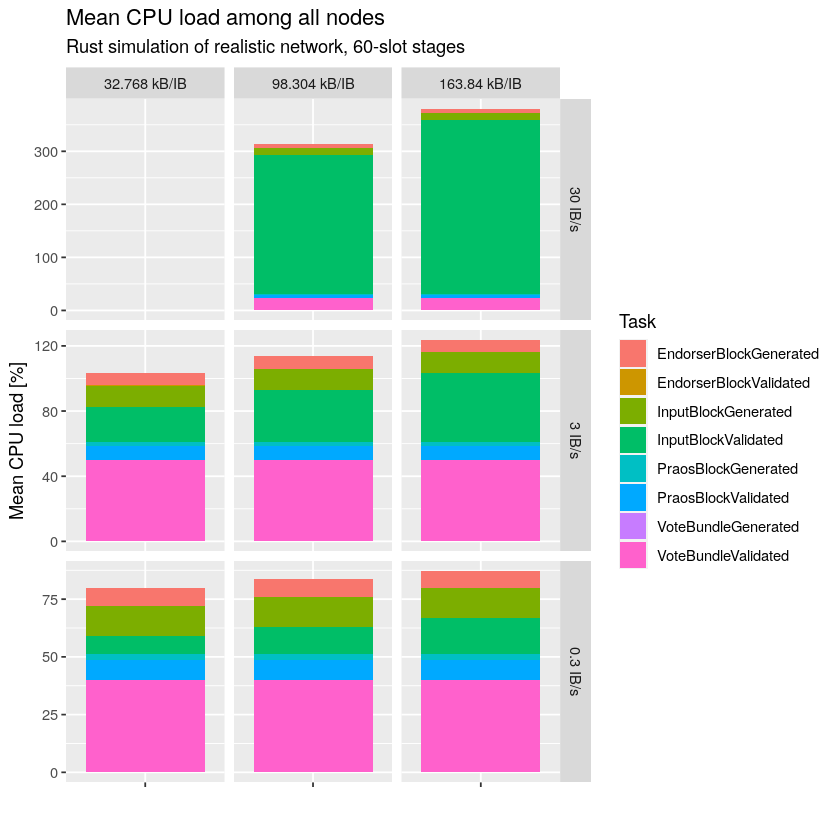

In [13]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=`task`
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

#### Time series

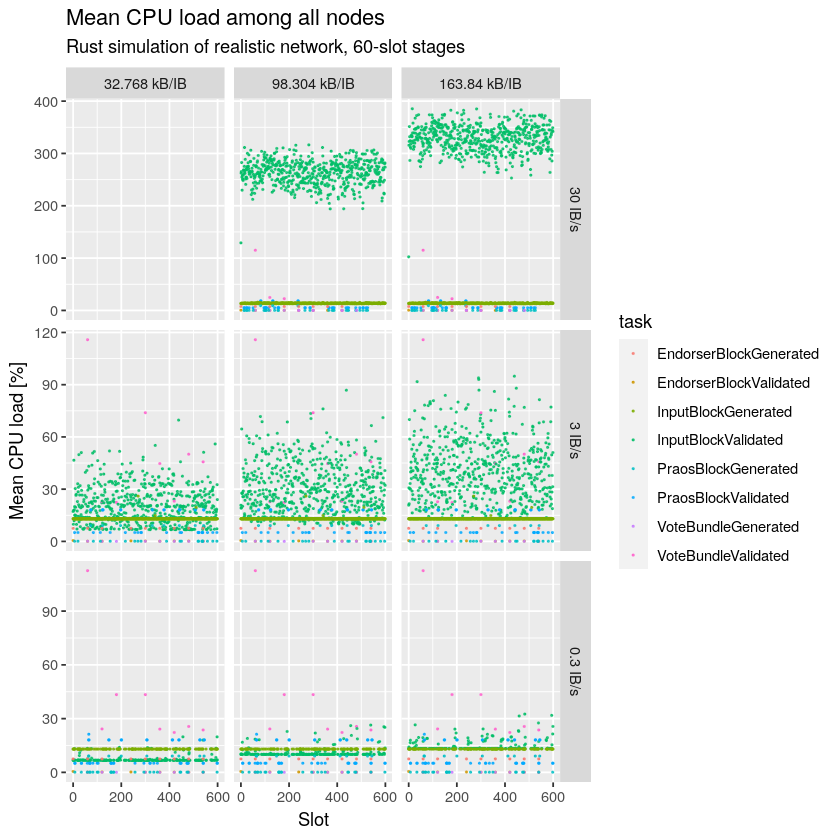

In [14]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

### Fraction throttled

In [15]:
# TBD

### Idle time

In [16]:
# TBD

## Input blocks

### Read results

In [17]:
if (file.exists("results/ibgen.csv.gz")) {
    ibgen <- fread("results/ibgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11xl", collection="ibgen")$find(), stringsAsFactors=TRUE)
    fwrite(ibgen, "results/ibgen.csv")
}
ibgen %>% summary

    eb-count         eb-first     eb-generation-probability    eb-last     
 Min.   :0.0000   Min.   :180.1   Min.   :1.5               Min.   :180.1  
 1st Qu.:0.0000   1st Qu.:240.1   1st Qu.:1.5               1st Qu.:240.1  
 Median :0.0000   Median :300.1   Median :1.5               Median :300.1  
 Mean   :0.4974   Mean   :316.8   Mean   :1.5               Mean   :316.8  
 3rd Qu.:1.0000   3rd Qu.:420.1   3rd Qu.:1.5               3rd Qu.:420.1  
 Max.   :3.0000   Max.   :540.1   Max.   :1.5               Max.   :540.1  
                  NA's   :26132                             NA's   :26132  
               ib        ib-body-avg-size-bytes ib-generation-probability
 0-node-1871-0  :    8   Min.   : 32768         Min.   : 0.30            
 362-node-1996-0:    6   1st Qu.: 98304         1st Qu.:30.00            
 0-node-1545-0  :    5   Median : 98304         Median :30.00            
 0-node-1841-0  :    5   Mean   :126479         Mean   :26.18            
 10-node-1946-0 :    5

### IB inculsion in EBs

#### Histogram

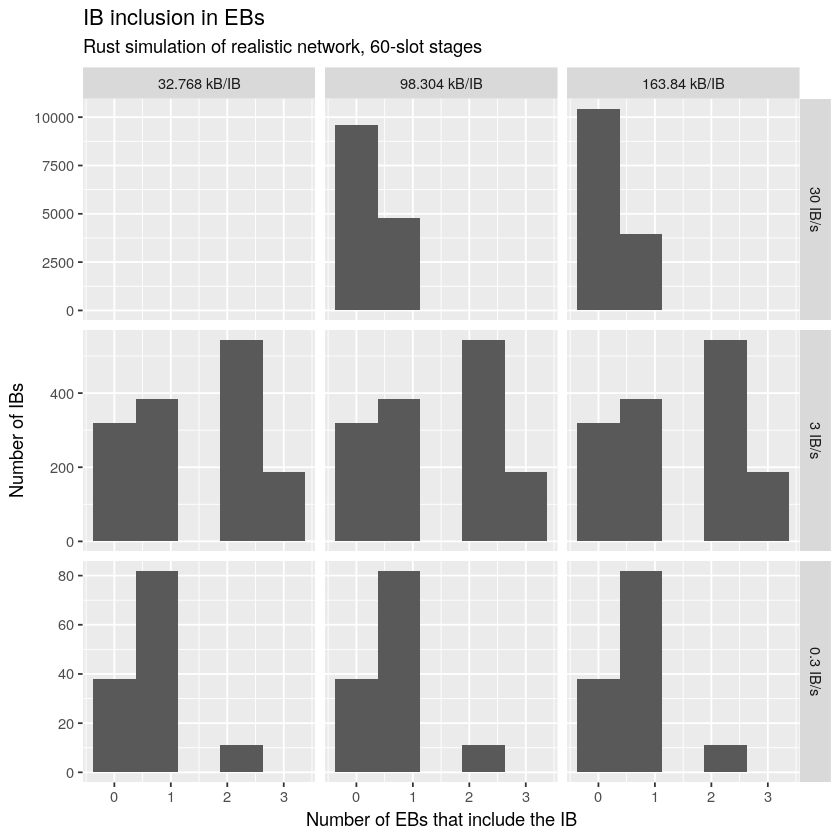

In [18]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

#### Time series

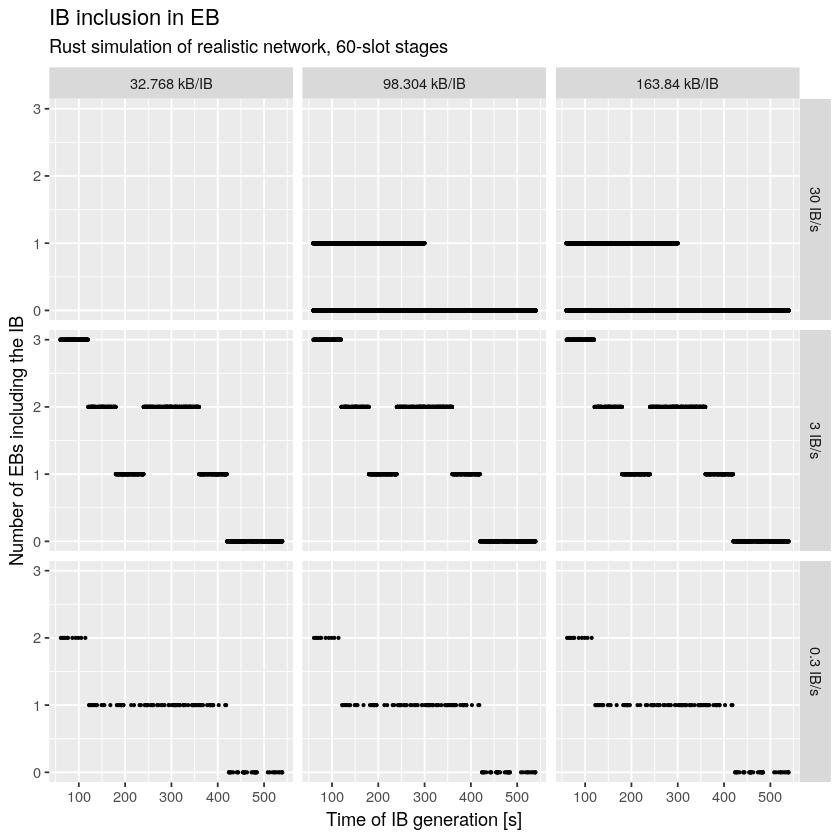

In [19]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

### Time of IB inclusion in an EB

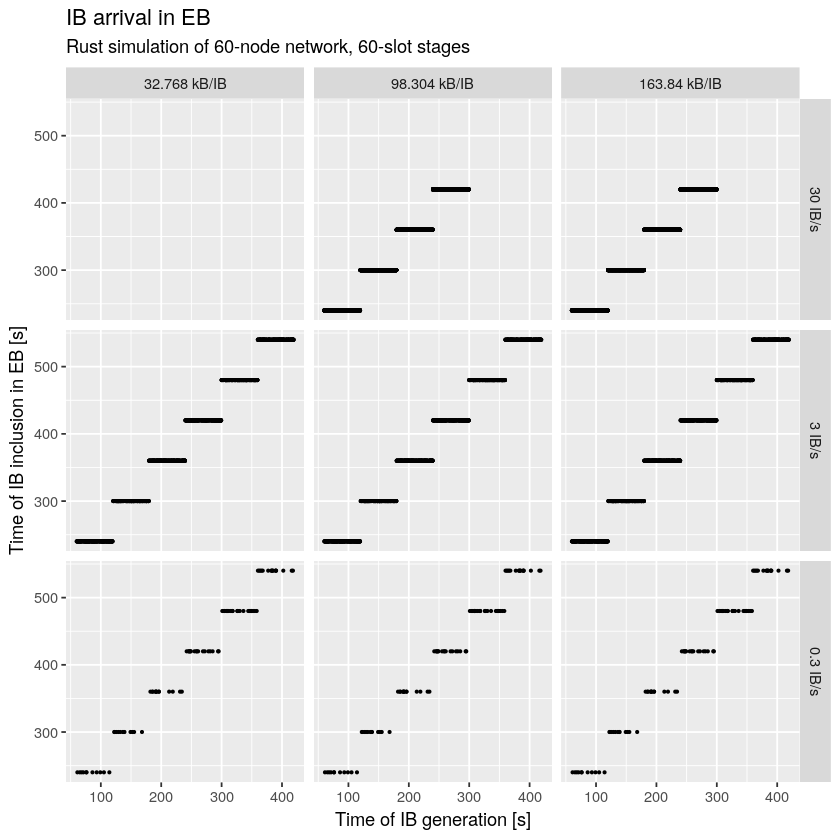

In [20]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & !is.na(`eb-first`) & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle=paste(s %>% str_to_title, "simulation of 60-node network, 60-slot stages"))
print(g)

}

### IB size

In [ ]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

## Endorser blocks

### Read results

In [22]:
if (file.exists("results/ebgen.csv.gz")) {
    ebgen <- fread("results/ebgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11xl", collection="ebgen")$find(), stringsAsFactors=TRUE)
    fwrite(ebgen, "results/ebgen.csv")
}
ebgen %>% summary

             eb     eb-generation-probability ib-body-avg-size-bytes
 0-node-1765  : 8   Min.   :1.5               Min.   : 32768        
 0-node-1834  : 8   1st Qu.:1.5               1st Qu.: 32768        
 0-node-1880  : 8   Median :1.5               Median : 98304        
 0-node-1885  : 8   Mean   :1.5               Mean   :105120        
 0-node-1933  : 8   3rd Qu.:1.5               3rd Qu.:163840        
 420-node-1976: 5   Max.   :1.5               Max.   :163840        
 (Other)      :80                                                   
    ib-count      ib-generation-probability     label    
 Min.   :   0.0   Min.   : 0.300            default:125  
 1st Qu.:   0.0   1st Qu.: 0.300                         
 Median :  11.0   Median : 3.000                         
 Mean   : 166.3   Mean   : 7.644                         
 3rd Qu.: 186.0   3rd Qu.: 3.000                         
 Max.   :1641.0   Max.   :30.000                         
                                          

### EB inclusion in RBs

#### Histogram

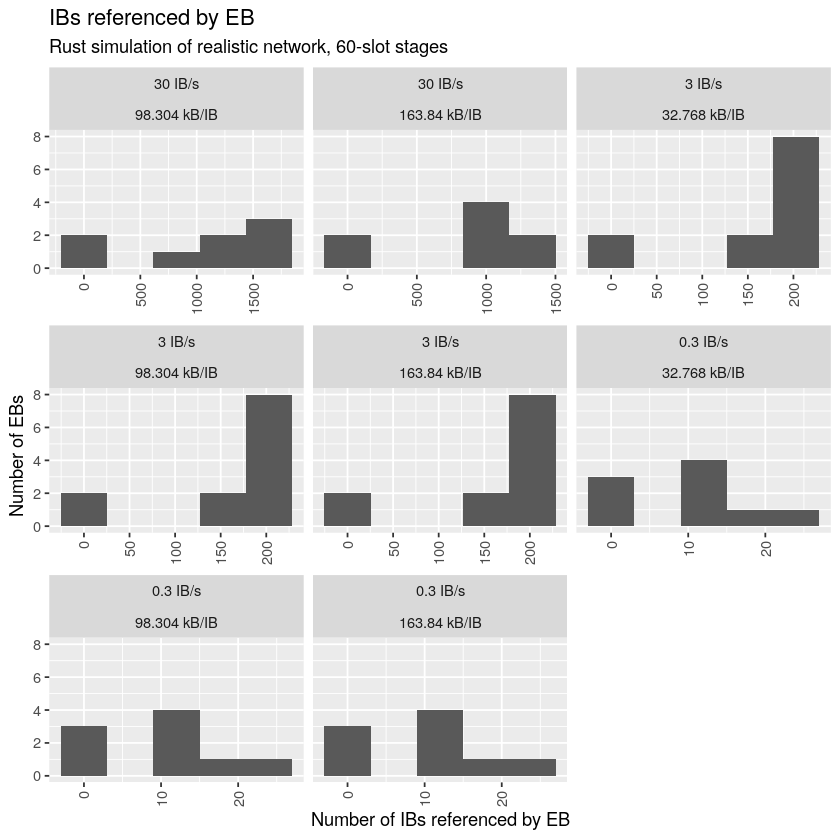

In [23]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(g)

}

#### Time series

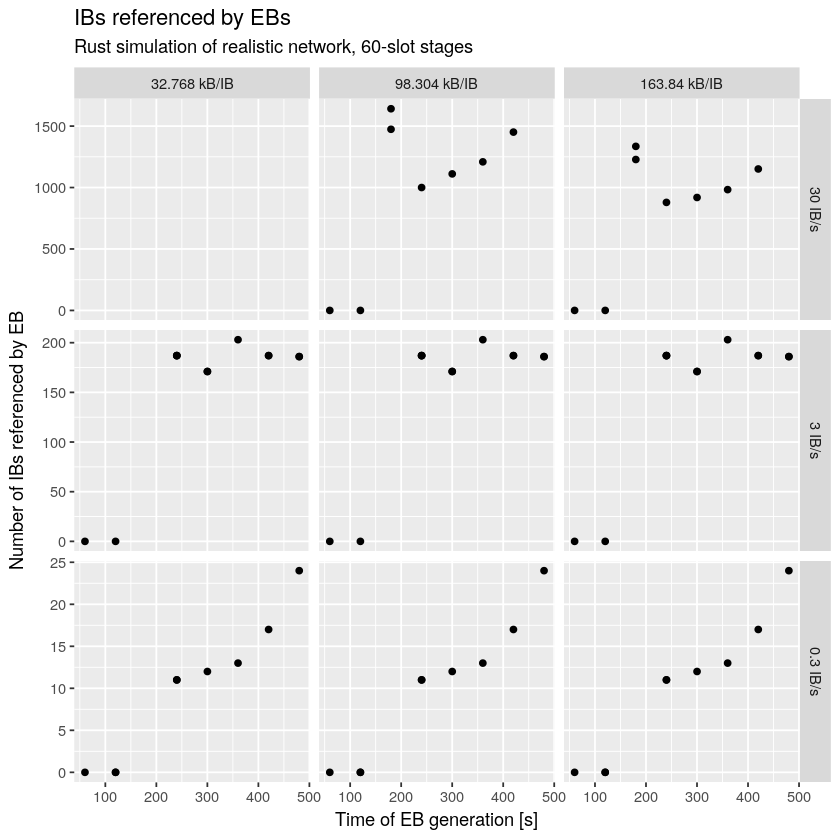

In [24]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

### EB inclusion in RBs

#### Histogram

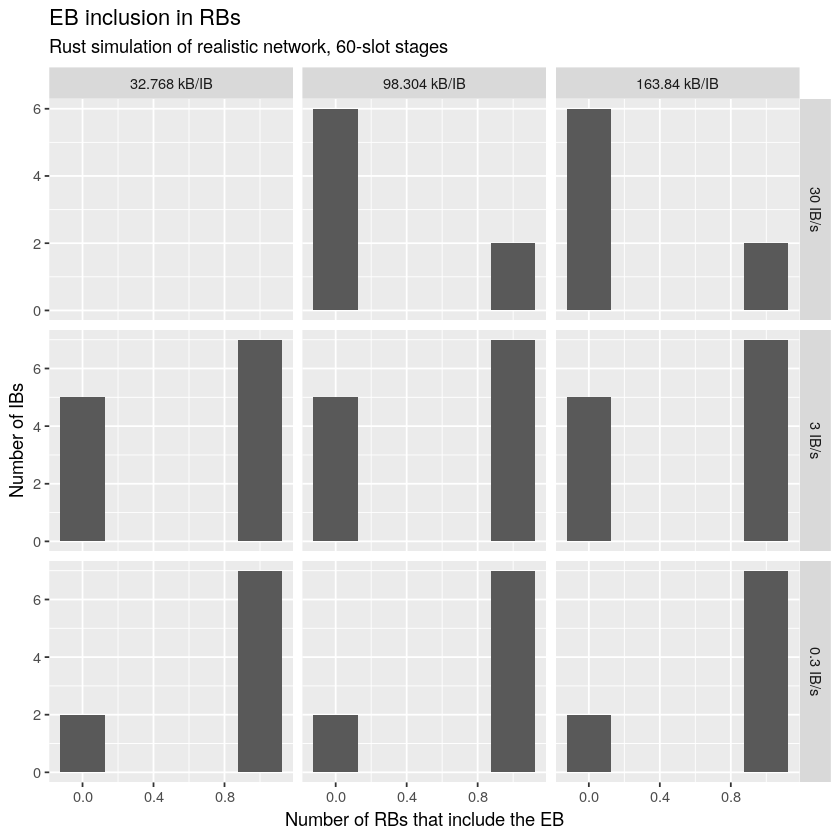

In [25]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("EB inclusion in RBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

#### Time series

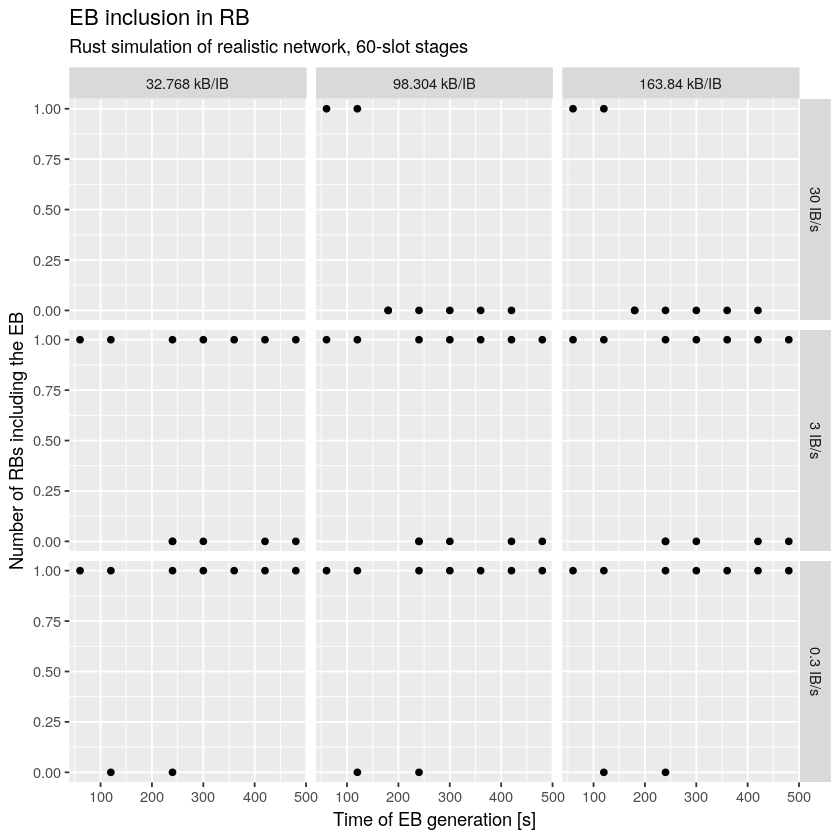

In [26]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

### Time of EB inclusion in an RB

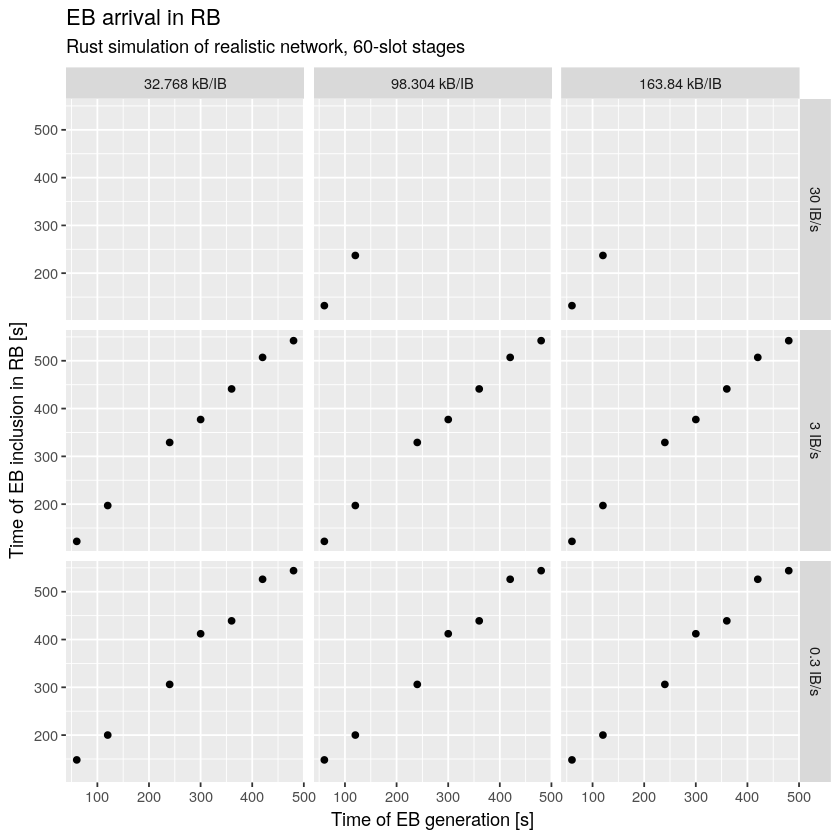

In [27]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & `rb-count` > 0 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)

}

### EB size

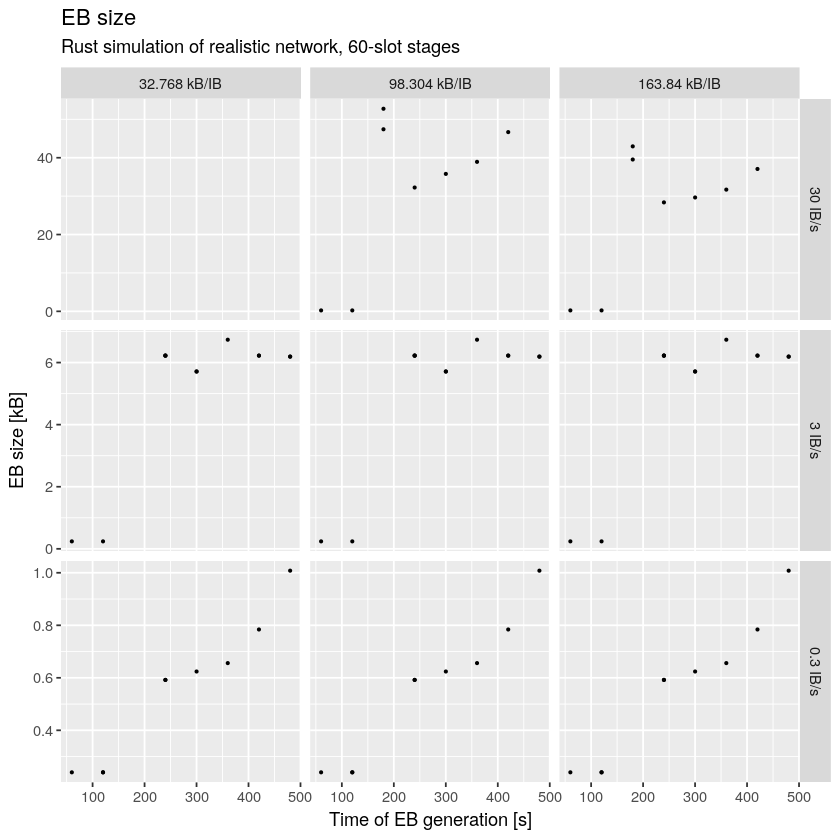

In [28]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

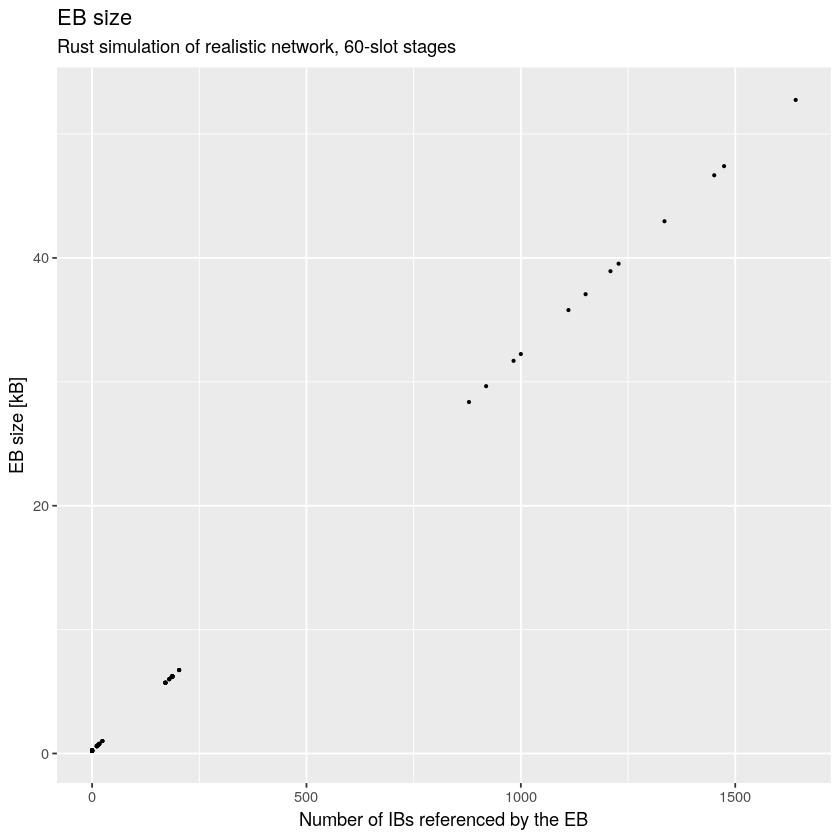

In [29]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by the EB`=`ib-count`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    #facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

## Ranking blocks

### Read results

In [30]:
if (file.exists("results/rbgen.csv.gz")) {
    rbgen <- fread("results/rbgen.csv.gz", stringsAsFactors=TRUE)
} else {
    rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11xl", collection="rbgen")$find(), stringsAsFactors=TRUE)
    fwrite(rbgen, "results/rbgen.csv")
}
rbgen %>% summary

    eb-count      eb-generation-probability ib-body-avg-size-bytes
 Min.   :0.0000   Min.   :1.5               Min.   : 32768        
 1st Qu.:0.0000   1st Qu.:1.5               1st Qu.: 81920        
 Median :0.0000   Median :1.5               Median : 98304        
 Mean   :0.2298   Mean   :1.5               Mean   :106496        
 3rd Qu.:0.0000   3rd Qu.:1.5               3rd Qu.:163840        
 Max.   :1.0000   Max.   :1.5               Max.   :163840        
                                                                  
 ib-generation-probability     label     leios-stage-length-slots
 Min.   : 0.300            default:248   Min.   :60              
 1st Qu.: 0.300                          1st Qu.:60              
 Median : 3.000                          Median :60              
 Mean   : 8.672                          Mean   :60              
 3rd Qu.: 9.750                          3rd Qu.:60              
 Max.   :30.000                          Max.   :60              
  

### EB inclusion in RBs

#### Histogram

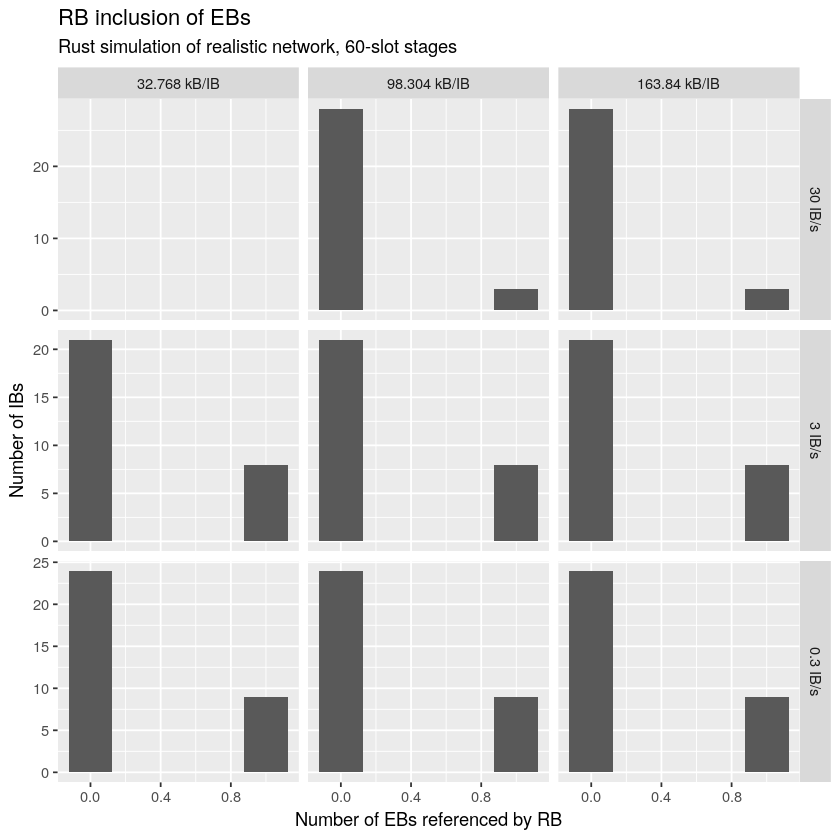

In [31]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

#### Time series

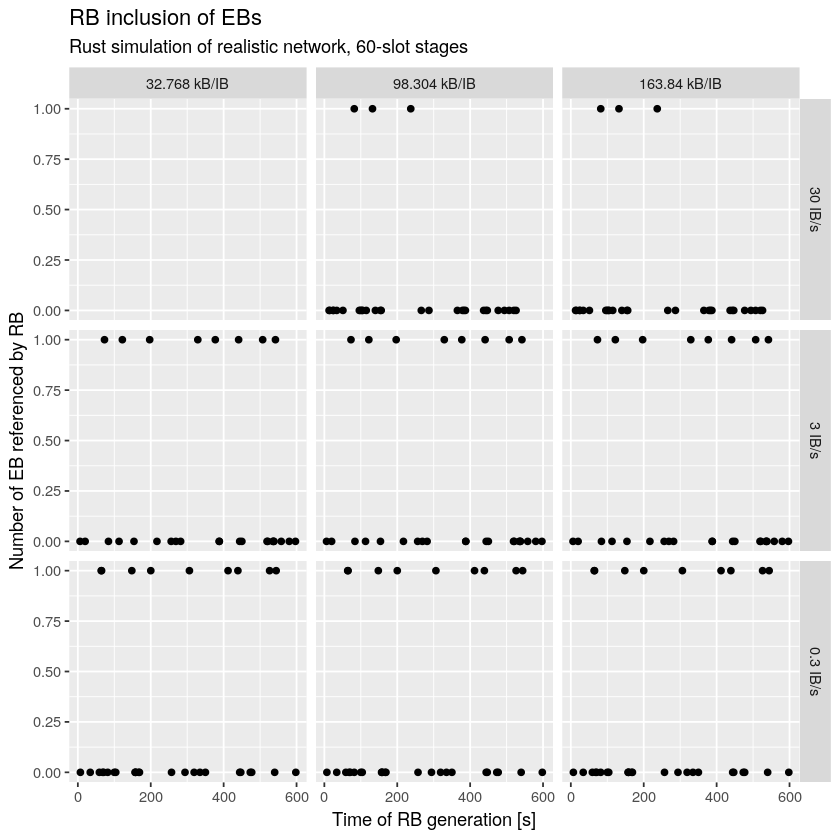

In [32]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}

### RB size

In [ ]:
for (s in cpusNode[,unique(`simulator`)]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
    
}